# New Code

[[0. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
case = [0, 0, 0, 0, 0] cost = 0
case = [1, 0, 0, 0, 0] cost = 1
case = [0, 1, 0, 0, 0] cost = 1
case = [1, 1, 0, 0, 0] cost = 0
case = [0, 0, 1, 0, 0] cost = 1
case = [1, 0, 1, 0, 0] cost = 0
case = [0, 1, 1, 0, 0] cost = 2
case = [1, 1, 1, 0, 0] cost = 0
case = [0, 0, 0, 1, 0] cost = 1
case = [1, 0, 0, 1, 0] cost = 0
case = [0, 1, 0, 1, 0] cost = 2
case = [1, 1, 0, 1, 0] cost = 0
case = [0, 0, 1, 1, 0] cost = 2
case = [1, 0, 1, 1, 0] cost = 0
case = [0, 1, 1, 1, 0] cost = 3
case = [1, 1, 1, 1, 0] cost = 0
case = [0, 0, 0, 0, 1] cost = 1
case = [1, 0, 0, 0, 1] cost = 0
case = [0, 1, 0, 0, 1] cost = 2
case = [1, 1, 0, 0, 1] cost = 0
case = [0, 0, 1, 0, 1] cost = 2
case = [1, 0, 1, 0, 1] cost = 0
case = [0, 1, 1, 0, 1] cost = 3
case = [1, 1, 1, 0, 1] cost = 0
case = [0, 0, 0, 1, 1] cost = 2
case = [1, 0, 0, 1, 1] cost = 0
case = [0, 1, 0, 1, 1] cost = 3
case = [1, 1, 0, 1, 1] cost = 0
case = [0, 0,

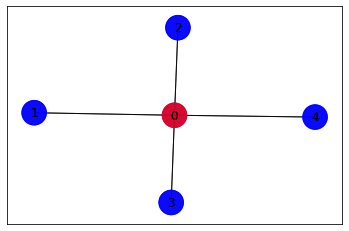

In [4]:
# useful additional packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.aqua.translators.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance

from docplex.mp.constants import ComparisonType
from docplex.mp.model import Model

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log
from qiskit import IBMQ

n=5 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,1,1.0),(0,2,1.0),(1,3,1.0),(0,4,1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ['b' for node in G.nodes()]
pos = nx.spring_layout(G)
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight']
print(w)
best_cost_brute = 0
xbest_brute =0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost_brute = 0
    var =True
    for i in range(n):
        for j in range(n):
            if ((w[i,j] ==1.) and (0  != x[i]*x[j])):
                var = False
    if (var == True):
        cost_brute = sum(x)

    if best_cost_brute < cost_brute:
        best_cost_brute = cost_brute
        xbest_brute = x
    print('case = ' + str(x)+ ' cost = ' + str(cost_brute))

colors = ['r' if xbest_brute[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))




# from docplex.mp.model import Model
# # from qiskit.aqua.translators.ising import docplex

# # Create an instance of a model and variables
# mdl = Model(name='max_ind')
# x = {i: mdl.binary_var(name='x_{0}'.format(i)) for i in range(0,n)}

# # Objective function
# max_vars_func = mdl.sum(x[i] for i in range(0,n))
# mdl.maximize(max_vars_func)

# # Constraints
# for i in range(n):
#     for j in range(i,n):
#         if (w[i,j] ==1.0):
#             mdl.add_constraint(x[i]*x[j]== 0)

# print(mdl.export_to_string())
# qubitOp, offset = get_qubitops(mdl)#docplex.get_qubitops(mdl)
# qubitOp.paulis
# #Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
# ee = ExactEigensolver(qubitOp, k=1)
# result = ee.run()

# print('energy:', result['energy'])
# print('objective:', result['energy'] + offset)

# x = docplex.sample_most_likely(result['eigvecs'][0])
# print('solution:', x)

In [5]:
import logging
from math import fsum
import warnings

import numpy as np
from docplex.mp.constants import ComparisonType
from docplex.mp.model import Model
from qiskit.quantum_info import Pauli

from qiskit.aqua import AquaError
from qiskit.aqua.operators import WeightedPauliOperator

logger = logging.getLogger(__name__)


def get_operator(mdl, auto_penalty=True, default_penalty=1e5):
    """ Generate Ising Hamiltonian from a model of DOcplex.

    Args:
        mdl (docplex.mp.model.Model): A model of DOcplex for a optimization problem.
        auto_penalty (bool): If true, the penalty coefficient is automatically defined
                             by "_auto_define_penalty()".
        default_penalty (float): The default value of the penalty coefficient for the constraints.
            This value is used if "auto_penalty" is False.

    Returns:
        tuple(operators.WeightedPauliOperator, float): operator for the Hamiltonian and a
        constant shift for the obj function.
    """

    _validate_input_model(mdl)

    # set the penalty coefficient by _auto_define_penalty() or manually.
    if auto_penalty:
        penalty = _auto_define_penalty(mdl, default_penalty)
    else:
        penalty = default_penalty

    # set a sign corresponding to a maximized or minimized problem.
    # sign == 1 is for minimized problem. sign == -1 is for maximized problem.
    sign = 1
    if mdl.is_maximized():
        sign = -1

    # assign variables of the model to qubits.
    q_d = {}
    index = 0
    for i in mdl.iter_variables():
        if i in q_d:
            continue
        q_d[i] = index
        index += 1

    # initialize Hamiltonian.
    num_nodes = len(q_d)
    pauli_list = []
    shift = 0
    zero = np.zeros(num_nodes, dtype=np.bool)

    # convert a constant part of the object function into Hamiltonian.
#     shift += mdl.get_objective_expr().get_constant() * sign

    # convert linear parts of the object function into Hamiltonian.
    l_itr = mdl.get_objective_expr().iter_terms()
    for j in l_itr:
        z_p = np.zeros(num_nodes, dtype=np.bool)
        index = q_d[j[0]] # coefficient
        weight = j[1] * sign / 2 # weight
        z_p[index] = True

        pauli_list.append([-weight, Pauli(z_p, zero)]) # if 1 apply X, if 0 apply Z
        shift += weight

    # convert quadratic parts of the object function into Hamiltonian.
#     q_itr = mdl.get_objective_expr().iter_quads()
#     for i in q_itr:
#         index1 = q_d[i[0][0]]
#         index2 = q_d[i[0][1]]
#         weight = i[1] * sign / 4

#         if index1 == index2:
#             shift += weight
#         else:
#             z_p = np.zeros(num_nodes, dtype=np.bool)
#             z_p[index1] = True
#             z_p[index2] = True
#             pauli_list.append([weight, Pauli(z_p, zero)])

#         z_p = np.zeros(num_nodes, dtype=np.bool)
#         z_p[index1] = True
#         pauli_list.append([-weight, Pauli(z_p, zero)])

#         z_p = np.zeros(num_nodes, dtype=np.bool)
#         z_p[index2] = True
#         pauli_list.append([-weight, Pauli(z_p, zero)])

#         shift += weight

    # convert constraints into penalty terms.
    
    
    for i in range(n):
        for j in range(i,n):
            if (w[i,j] ==1.0):
                index1 = i # coefficient
                index2 = j # index coefficient
#                 weight1 = __l[1]
                weight1 = 1
                weight2 = 1
#                 weight2 = l_2[1]
                
                # constant penalty
                shift += 0.25 * penalty
                
                # linear penalty
                linear_penalty = penalty/4
                z_p = np.zeros(num_nodes, dtype=np.bool)
                z_p[index1] = True
                pauli_list.append([-linear_penalty, Pauli(z_p, zero)])

                z_p = np.zeros(num_nodes, dtype=np.bool)
                z_p[index2] = True
                pauli_list.append([-linear_penalty, Pauli(z_p, zero)])
                
                # quadratic penalty
                penalty_weight1_weight2 = penalty * weight1 * weight2 / 4
        

#                 if index1 == index2:
#                     shift += penalty_weight1_weight2
#                 else:
#                     z_p = np.zeros(num_nodes, dtype=np.bool)
#                     z_p[index1] = True
#                     z_p[index2] = True
#                     pauli_list.append([penalty_weight1_weight2, Pauli(z_p, zero)])
                
                z_p = np.zeros(num_nodes, dtype=np.bool)
                z_p[index1] = True
                z_p[index2] = True
                pauli_list.append([-penalty_weight1_weight2, Pauli(z_p, zero)])

#                 shift += penalty_weight1_weight2
    
    
    
#     for constraint in mdl.iter_constraints():
#         constant = constraint.right_expr.get_constant()

#         # constant parts of penalty*(Constant-func)**2: penalty*(Constant**2)
# #         shift += penalty * constant ** 2

#         # linear parts of penalty*(Constant-func)**2: penalty*(-2*Constant*func)
# #         for __l in constraint.left_expr.iter_terms():
# #             z_p = np.zeros(num_nodes, dtype=np.bool)
# #             index = q_d[__l[0]]
# #             weight = __l[1]
# #             z_p[index] = True

# #             pauli_list.append([penalty * constant * weight, Pauli(z_p, zero)])
# #             shift += -penalty * constant * weight

#         # quadratic parts of penalty*(Constant-func)**2: penalty*(func**2)
    
#         for i in range(n):
#             for j in range(i,n):
#                 if (w[i,j] ==1.0):
#                     mdl.add_constraint(x[i]*x[j]== 0)
                    
#         for l_2 in constraint.left_expr.iter_terms():
#             for i in range()
#                 index1 = q_d[i[0]] # coefficient
#                 index2 = q_d[j[0]] # index coefficient
# #                 weight1 = __l[1]
#                 weight1 = 1
#                 weight2 = 1
# #                 weight2 = l_2[1]
#                 penalty_weight1_weight2 = penalty * weight1 * weight2 / 4

# #                 if index1 == index2:
# #                     shift += penalty_weight1_weight2
# #                 else:
# #                     z_p = np.zeros(num_nodes, dtype=np.bool)
# #                     z_p[index1] = True
# #                     z_p[index2] = True
# #                     pauli_list.append([penalty_weight1_weight2, Pauli(z_p, zero)])
                
#                 z_p = np.zeros(num_nodes, dtype=np.bool)
#                 z_p[index1] = True
#                 pauli_list.append([-penalty_weight1_weight2, Pauli(z_p, zero)])

#                 z_p = np.zeros(num_nodes, dtype=np.bool)
#                 z_p[index2] = True
#                 pauli_list.append([-penalty_weight1_weight2, Pauli(z_p, zero)])

#                 shift += penalty_weight1_weight2

    # Remove paulis whose coefficients are zeros.
    qubit_op = WeightedPauliOperator(paulis=pauli_list)

    return qubit_op, shift


def _validate_input_model(mdl):
    """ Check whether an input model is valid. If not, raise an AquaError

    Args:
         mdl (docplex.mp.model.Model): A model of DOcplex for a optimization problem.
    Raises:
        AquaError: Unsupported input model
    """
    valid = True

    # validate an object type of the input.
    if not isinstance(mdl, Model):
        raise AquaError('An input model must be docplex.mp.model.Model.')

    # raise an error if the type of the variable is not a binary type.
    for var in mdl.iter_variables():
        if not var.is_binary():
            logger.warning('The type of Variable %s is %s. It must be a binary variable. ',
                           var, var.vartype.short_name)
            valid = False

    # raise an error if the constraint type is not an equality constraint.
    for constraint in mdl.iter_constraints():
        if not constraint.sense == ComparisonType.EQ:
            logger.warning('Constraint %s is not an equality constraint.', constraint)
            valid = False

    if not valid:
        raise AquaError('The input model has unsupported elements.')


def _auto_define_penalty(mdl, default_penalty=1e5):
    """ Automatically define the penalty coefficient.
    This returns object function's (upper bound - lower bound + 1).


    Args:
        mdl (docplex.mp.model.Model): A model of DOcplex for a optimization problem.
        default_penalty (float): The default value of the penalty coefficient for the constraints.

    Returns:
        float: The penalty coefficient for the Hamiltonian.
    """

    # if a constraint has float coefficient, return 1e5 for the penalty coefficient.
    terms = []
    for constraint in mdl.iter_constraints():
        terms.append(constraint.right_expr.get_constant())
        terms.extend(term[1] for term in constraint.left_expr.iter_terms())
    if any(isinstance(term, float) and not term.is_integer() for term in terms):
        logger.warning('Using %f for the penalty coefficient because a float coefficient exists '
                       'in constraints. \nThe value could be too small. '
                       'If so, set the penalty coefficient manually.', default_penalty)
        return default_penalty

    # (upper bound - lower bound) can be calculate as the sum of absolute value of coefficients
    # Firstly, add 1 to guarantee that infeasible answers will be greater than upper bound.
    penalties = [1]
    # add linear terms of the object function.
    penalties.extend(abs(i[1]) for i in mdl.get_objective_expr().iter_terms())
    # add quadratic terms of the object function.
    penalties.extend(abs(i[1]) for i in mdl.get_objective_expr().iter_quads())

    return fsum(penalties)


def sample_most_likely(state_vector):
    """ sample most likely """
    from .common import sample_most_likely as redirect_func
    warnings.warn("sample_most_likely function has been moved to qiskit.optimization.ising.common, "
                  "the method here will be removed after Aqua 0.7+",
                  DeprecationWarning)
    return redirect_func(state_vector=state_vector)


def get_qubitops(mdl, auto_penalty=True, default_penalty=1e5):
    """ get qubit ops """
    warnings.warn("get_qubitops function has been changed to get_operator."
                  " The method here will be removed after Aqua 0.7+",
                  DeprecationWarning)
    return get_operator(mdl, auto_penalty, default_penalty)


In [6]:
from docplex.mp.model import Model
from qiskit.aqua.translators.ising import docplex

# Create an instance of a model and variables
mdl = Model(name='max_ind')
x = {i: mdl.binary_var(name='x_{0}'.format(i)) for i in range(0,n)}

# Objective function
max_vars_func = mdl.sum(x[i] for i in range(0,n))
mdl.maximize(max_vars_func)

# Constraints
for i in range(n):
    for j in range(i,n):
        if (w[i,j] ==1.0):
            mdl.add_constraint(x[i]*x[j]== 0)

print(mdl.export_to_string())
qubitOp, offset = get_qubitops(mdl)#docplex.get_qubitops(mdl)
qubitOp.paulis
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = ExactEigensolver(qubitOp, k=1)
result = ee.run()

print('energy:', result['energy'])
print('objective:', result['energy'] + offset)

x = docplex.sample_most_likely(result['eigvecs'][0])
print('solution:', x)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: max_ind

Maximize
 obj: x_0 + x_1 + x_2 + x_3 + x_4
Subject To
 qc1: [ x_0*x_1 ] = 0
 qc2: [ x_0*x_2 ] = 0
 qc3: [ x_0*x_3 ] = 0
 qc4: [ x_0*x_4 ] = 0

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4
End

energy: -15.5
objective: -12.0
solution: [0. 0. 0. 0. 0.]


/Users/tinkertanker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:282: DeprecationWarning: get_qubitops function has been changed to get_operator. The method here will be removed after Aqua 0.7+
